# Discrete Anomaly Detection

In [35]:
import itertools
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns

## Acquire

In [36]:
colnames = ["ip", "timestamp", "request_method", "status", "size",
            "destination", "request_agent"]

df_orig = pd.read_csv("http://python.zach.lol/access.log",
                      engine="python",
                      header=None,
                      index_col=False,
                      names=colnames,
                      sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                      na_values='"-"',
                      usecols=[0, 3, 4, 5, 6, 7, 8])

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

In [37]:
df = df_orig.append(new)

In [38]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
ip                13978 non-null object
timestamp         13978 non-null object
request_method    13978 non-null object
status            13978 non-null int64
size              13978 non-null int64
destination       25 non-null object
request_agent     13978 non-null object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


## Preparation

### Parse Datetime

In [40]:
df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True)
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1))
df = df.set_index('timestamp').tz_localize(None)

### Clean Up Text

In [41]:
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

In [42]:
df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [43]:
df["request_agent"] = df.request_agent.str.replace(r" .+", '', 1, regex=True)

### Convert Bytes to MB

In [44]:
# df['size_mb'] = [n/1024/1024 for n in df['size']]
df["size_mb"] = df["size"] / 1024 / 1024

In [45]:
df.describe()

,status,size,size_mb
count,13978.000000,1.397800e+04,13978.000000
mean,200.356703,4.500019e+05,0.429155
std,10.182001,1.614915e+05,0.154010
min,200.000000,0.000000e+00,0.000000
25%,200.000000,5.006370e+05,0.477445
50%,200.000000,5.101380e+05,0.486506
75%,200.000000,5.112910e+05,0.487605
max,499.000000,2.056327e+06,1.961066


In [46]:
df.request_agent.value_counts(dropna=False).reset_index()

,index,request_agent
0,python-requests/2.21.0,12005
1,python-requests/2.20.1,1911
2,Mozilla/5.0,48
3,Slackbot-LinkExpanding,7
4,Slackbot,6
5,Python-urllib/3.7,1


In [47]:
df_ra_count = pd.DataFrame(df.request_agent.value_counts(dropna=False))\
                 .reset_index()\
                 .rename(columns={"index": "request_method", "request_agent": "request_agent_count"})

In [48]:
df_ra_count.head()

,request_method,request_agent_count
0,python-requests/2.21.0,12005
1,python-requests/2.20.1,1911
2,Mozilla/5.0,48
3,Slackbot-LinkExpanding,7
4,Slackbot,6


In [49]:
df.request_agent.value_counts(dropna=False) / df.request_agent.count()

python-requests/2.21.0    0.858850
python-requests/2.20.1    0.136715
Mozilla/5.0               0.003434
Slackbot-LinkExpanding    0.000501
Slackbot                  0.000429
Python-urllib/3.7         0.000072
Name: request_agent, dtype: float64

In [50]:
df_ra_proba = pd.DataFrame(df.request_agent.value_counts(dropna=False) / df.request_agent.count())\
                 .reset_index()\
                 .rename(columns={"index": "request_method", "request_agent": "request_agent_proba"})

In [51]:
df_ra_proba.head()

,request_method,request_agent_proba
0,python-requests/2.21.0,0.858850
1,python-requests/2.20.1,0.136715
2,Mozilla/5.0,0.003434
3,Slackbot-LinkExpanding,0.000501
4,Slackbot,0.000429


In [52]:
df_ra = df_ra_count.merge(df_ra_proba)

In [53]:
df_ra

,request_method,request_agent_count,request_agent_proba
0,python-requests/2.21.0,12005,0.858850
1,python-requests/2.20.1,1911,0.136715
2,Mozilla/5.0,48,0.003434
3,Slackbot-LinkExpanding,7,0.000501
4,Slackbot,6,0.000429
5,Python-urllib/3.7,1,0.000072


### Low Probabilities

In [54]:
df_ra[df_ra.request_agent_proba < 0.01]

,request_method,request_agent_count,request_agent_proba
2,Mozilla/5.0,48,0.003434
3,Slackbot-LinkExpanding,7,0.000501
4,Slackbot,6,0.000429
5,Python-urllib/3.7,1,0.000072


### Visualize

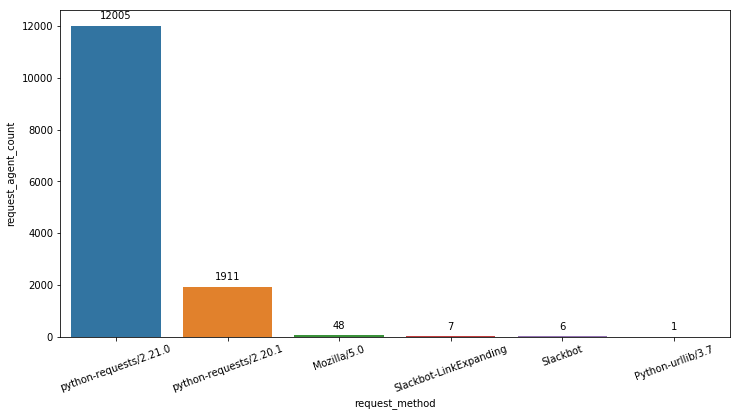

In [55]:
plt.figure(figsize=(12, 6))
splot = sns.barplot(data=df_ra, x="request_method", y="request_agent_count", ci=None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), ".0f"),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha="center", va="center", xytext=(0, 10),
                   textcoords="offset points")
    plt.xticks(rotation=20)

In [56]:
df.columns

Index(['ip', 'request_method', 'status', 'size', 'destination',
       'request_agent', 'size_mb'],
      dtype='object')

In [57]:
df.index.min()

Timestamp('2019-04-16 19:34:42')

In [58]:
df[df.index < "2019-04-18"].tail()

,ip,request_method,status,size,destination,request_agent,size_mb
timestamp,,,,,,,
2019-04-17 12:55:12,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511201,NaN,python-requests/2.21.0,0.487519
2019-04-17 12:55:13,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511781,NaN,python-requests/2.21.0,0.488072
2019-04-17 12:55:13,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510136,NaN,python-requests/2.21.0,0.486504
2019-04-17 12:55:14,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510166,NaN,python-requests/2.21.0,0.486532
2019-04-17 19:36:41,95.31.16.121,GET /api/v1/sales/HTTP/1.1,301,1005,NaN,python-requests/2.21.0,0.000958


In [59]:
train = df["2019-04-16 19:34:42":"2019-04-17 12:55:14"]

In [62]:
df_ra = pd.DataFrame(train.request_agent.value_counts(dropna=False) / train.request_agent.count())\
          .reset_index()\
          .rename(columns={"index": "request_agent", "request_agent": "ra_prob"})

In [65]:
df_ra

,request_agent,ra_prob
0,python-requests/2.21.0,0.858799
1,python-requests/2.20.1,0.136764
2,Mozilla/5.0,0.003435
3,Slackbot-LinkExpanding,0.000501
4,Slackbot,0.000429
5,Python-urllib/3.7,0.000072


In [71]:
train.request_agent.value_counts(dropna=False)

python-requests/2.21.0    12000
python-requests/2.20.1     1911
Mozilla/5.0                  48
Slackbot-LinkExpanding        7
Slackbot                      6
Python-urllib/3.7             1
Name: request_agent, dtype: int64

In [67]:
df = df.reset_index().merge(df_ra, on="request_agent", how="left")\
                .fillna(value=0).set_index("timestamp")

In [68]:
df.ra_prob.value_counts(dropna=False)

0.858799    12005
0.136764     1911
0.003435       48
0.000501        7
0.000429        6
0.000072        1
Name: ra_prob, dtype: int64

In [72]:
df[df.request_agent == "Python-urllib/3.7"]

,ip,request_method,status,size,destination,request_agent,size_mb,ra_prob
timestamp,,,,,,,,
2019-04-16 20:57:38,97.105.19.58,GET /api/v1/items&page=0 HTTP/1.1,200,162,0,Python-urllib/3.7,0.000154,0.000072


In [73]:
df[df.request_agent == "Slackbot"]

,ip,request_method,status,size,destination,request_agent,size_mb,ra_prob
timestamp,,,,,,,,
2019-04-16 19:39:15,52.90.165.200,GET /favicon.ico HTTP/1.1,200,162,0,Slackbot,0.000154,0.000429
2019-04-16 19:40:33,34.207.64.242,GET /favicon.ico HTTP/1.1,200,162,0,Slackbot,0.000154,0.000429
2019-04-16 19:40:37,34.229.70.250,GET /favicon.ico HTTP/1.1,200,162,0,Slackbot,0.000154,0.000429
2019-04-16 21:22:22,54.145.52.184,GET /favicon.ico HTTP/1.1,200,162,0,Slackbot,0.000154,0.000429
2019-04-16 21:38:57,35.174.209.2,GET /favicon.ico HTTP/1.1,200,162,0,Slackbot,0.000154,0.000429
2019-04-17 02:14:28,52.87.230.102,GET /favicon.ico HTTP/1.1,200,162,0,Slackbot,0.000154,0.000429


## Conditional Probability

**Given a particular request_agent, what is the likelihood of the request_method?**

In [74]:
ra_probs = train.groupby("request_agent").size().div(len(df))

In [75]:
ra_probs

request_agent
Mozilla/5.0               0.003434
Python-urllib/3.7         0.000072
Slackbot                  0.000429
Slackbot-LinkExpanding    0.000501
python-requests/2.20.1    0.136715
python-requests/2.21.0    0.858492
dtype: float64

In [76]:
request_given_agent = pd.DataFrame(train.groupby(["request_agent", "request_method"])\
                                   .size().div(len(train))\
                                   .div(ra_probs, axis=0, level="request_agent")\
                                   .reset_index()\
                                   .rename(columns={0: "proba_request_given_agent"}))

In [80]:
request_given_agent.head()

,request_agent,request_method,proba_request_given_agent
0,Mozilla/5.0,GET / HTTP/1.1,0.104204
1,Mozilla/5.0,GET /api/V1/HiZach! HTTP/1.1,0.020841
2,Mozilla/5.0,GET /api/v1/ HTTP/1.1,0.041682
3,Mozilla/5.0,GET /api/v1//api/v1/items HTTP/1.1,0.041682
4,Mozilla/5.0,GET /api/v1//api/v1/items/next_page HTTP/1.1,0.020841


In [87]:
request_given_agent.set_index("proba_request_given_agent").sort_values(by="proba_request_given_agent")

,request_agent,request_method
proba_request_given_agent,,
0.000083,python-requests/2.21.0,GET /api/v1/ HTTP/1.1
0.000083,python-requests/2.21.0,GET /api/v1 HTTP/1.1
0.000167,python-requests/2.21.0,GET /api/v1items HTTP/1.1
0.000250,python-requests/2.21.0,GET /api/v1/store HTTP/1.1
0.000250,python-requests/2.21.0,GET /api/v1/sales/ HTTP/1.1
0.000250,python-requests/2.21.0,GET /api/v1/itemsitems HTTP/1.1
0.000417,python-requests/2.21.0,GET /api/v1/items/next_page HTTP/1.1
0.000584,python-requests/2.21.0,GET /api/v1/items/api/v1/items HTTP/1.1
0.000750,python-requests/2.21.0,GET /api/v1//api/v1/items HTTP/1.1


In [89]:
df = df.reset_index().merge(request_given_agent, on=["request_agent", "request_method"], how="left").fillna(value=0)\
                .set_index("timestamp")

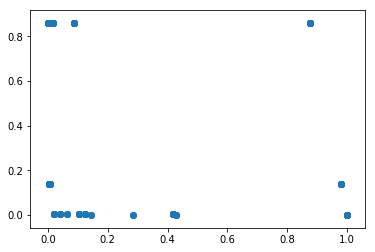

In [90]:
plt.scatter(df.proba_request_given_agent, df.ra_prob)

In [ ]:
df.